In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

/Users/karan/Coding/Python/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

# Define the locations and date range
locations = ["Earhart", "Ford", "Hillenbrand", "Wiley", "Windsor"]
start_date = datetime(2023, 10, 1)
end_date = datetime(2023, 10, 31)
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

In [4]:

# Initialize the DataFrame with dates as the index
df_items = pd.DataFrame(index=[date.strftime('%Y-%m-%d') for date in date_range], columns=locations)

# Initialize each cell in the DataFrame as an empty list
for location in locations:
    for date in df_items.index:
        df_items.at[date, location] = []

# Save the DataFrame to a CSV file to confirm the initialization
# df_items.to_csv('menu_items_grouped.csv')

In [ ]:
# Loop through each location and each date
for location in locations:
    for date in date_range:
        date_str = date.strftime('%Y-%m-%d')
        url = f'https://api.hfs.purdue.edu/menus/v2/locations/{location}/{date_str}'

        # Make the API call
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()

            # Initialize a list to hold meal data for this location and date
            meals_list = []

            # Parse the JSON response and extract the items grouped by meal
            for meal in data['Meals']:
                meal_id = meal['ID']
                item_ids = []
                for station in meal['Stations']:
                    for item in station['Items']:
                        item_ids.append(item['ID'])
                meals_list.append({'meal_id': meal_id, 'item_ids': item_ids})

            # Assign the list to the appropriate cell in the DataFrame
            df_items.at[date_str, location] = meals_list

        # Sleep for 500 ms before the next API call
        time.sleep(0.5)

# Save the DataFrame to a CSV file
df_items.to_csv('menu_items_grouped.csv')

In [17]:
# Print out the DataFrame structure
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 2023-10-01 to 2023-10-31
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Earhart      31 non-null     object
 1   Ford         31 non-null     object
 2   Hillenbrand  31 non-null     object
 3   Wiley        31 non-null     object
 4   Windsor      31 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


In [31]:
item_id_test = df_items["Ford"].iloc[1][0]["item_ids"][0]
items_url = f"https://api.hfs.purdue.edu/menus/v2/items/{item_id_test}"
res = requests.get(items_url).json()
print(res)

In [30]:
res

{'Nutrition': [{'Name': 'Serving Size',
   'LabelValue': '1/2 Cup',
   'DailyValue': None,
   'Ordinal': 0},
  {'Name': 'Calories',
   'Value': 160.2958,
   'LabelValue': '160',
   'DailyValue': None,
   'Ordinal': 1},
  {'Name': 'Calories from fat',
   'LabelValue': '99',
   'DailyValue': None,
   'Ordinal': 2},
  {'Name': 'Total fat',
   'Value': 10.8805,
   'LabelValue': '11g',
   'DailyValue': '17%',
   'Ordinal': 3},
  {'Name': 'Saturated fat',
   'Value': 2.6405,
   'LabelValue': '2.5g',
   'DailyValue': '13%',
   'Ordinal': 4},
  {'Name': 'Cholesterol',
   'Value': 311.3398,
   'LabelValue': '310mg',
   'DailyValue': '104%',
   'Ordinal': 5},
  {'Name': 'Sodium',
   'Value': 416.0545,
   'LabelValue': '420mg',
   'DailyValue': '17%',
   'Ordinal': 6},
  {'Name': 'Total Carbohydrate',
   'Value': 2.9257,
   'LabelValue': '3g',
   'DailyValue': '1%',
   'Ordinal': 7},
  {'Name': 'Sugar',
   'Value': 0.0,
   'LabelValue': '0g',
   'DailyValue': None,
   'Ordinal': 8},
  {'Name': 'A

In [41]:
# Assume df_items is already created and filled with meal data

# Set up a DataFrame for nutritional data
nutritional_data_columns = [
    'ItemID', 'Name', 'ServingSize', 'Calories', 'TotalFat', 'SaturatedFat', 'Cholesterol', 
    'Sodium', 'TotalCarbohydrate', 'DietaryFiber', 'Sugars', 'Protein', 'Calcium', 'Iron',
    'IsVegetarian', 'Ingredients', 'Allergens'
]
df_nutritional_details = pd.DataFrame(columns=nutritional_data_columns)

# Collect all nutritional details in a list
nutritional_details_list = []

# Collect all unique item IDs from df_items
unique_item_ids = set()
for location in df_items.columns:
    for meal_list in df_items[location]:
        for meal in meal_list:
            unique_item_ids.update(meal['item_ids'])

# Define a function to extract nutritional values from the response
def extract_nutrition(nutrition_info, name):
    for nutrient in nutrition_info:
        if nutrient['Name'].lower() == name.lower():
            return nutrient.get('Value') or nutrient.get('LabelValue')
    return None


In [42]:
# Iterate over the unique item IDs and fetch nutritional data
for item_id in unique_item_ids:
    items_url = f"https://api.hfs.purdue.edu/menus/v2/items/{item_id}"
    response = requests.get(items_url)
    if response.status_code == 200:
        item_data = response.json()

        if item_data.get('NutritionReady', False):
            # Parse nutritional data
            nutrition_info = item_data.get('Nutrition', [])
            nutritional_details = {
                'ItemID': item_id,
                'Name': item_data['Name'],
                'ServingSize': extract_nutrition(nutrition_info, 'Serving Size'),
                'Calories': extract_nutrition(nutrition_info, 'Calories'),
                'TotalFat': extract_nutrition(nutrition_info, 'Total fat'),
                'SaturatedFat': extract_nutrition(nutrition_info, 'Saturated fat'),
                'Cholesterol': extract_nutrition(nutrition_info, 'Cholesterol'),
                'Sodium': extract_nutrition(nutrition_info, 'Sodium'),
                'TotalCarbohydrate': extract_nutrition(nutrition_info, 'Total Carbohydrate'),
                'DietaryFiber': extract_nutrition(nutrition_info, 'Dietary Fiber'),
                'Sugars': extract_nutrition(nutrition_info, 'Sugar'),
                'Protein': extract_nutrition(nutrition_info, 'Protein'),
                'Calcium': extract_nutrition(nutrition_info, 'Calcium'),
                'Iron': extract_nutrition(nutrition_info, 'Iron'),
                'IsVegetarian': item_data['IsVegetarian'],
                'Ingredients': item_data.get('Ingredients', ''),
                'Allergens': [allergen['Name'] for allergen in item_data.get('Allergens', []) if allergen['Value']]
            }
        else:
            # No nutritional data available; create a record with None values
            nutritional_details = {col: None for col in nutritional_data_columns}
            nutritional_details.update({
                'ItemID': item_id,
                'Name': item_data['Name'],
                'IsVegetarian': item_data['IsVegetarian'],
                'Ingredients': item_data.get('Ingredients', ''),
                'Allergens': [allergen['Name'] for allergen in item_data.get('Allergens', []) if allergen['Value']]
            })

        # Append to the nutritional details DataFrame
        nutritional_details_list.append(nutritional_details)
    
    # Sleep to prevent hitting API rate limits
    time.sleep(0.5)

df_nutritional_details = pd.DataFrame(nutritional_details_list)
# Once the loop is done, you have your nutritional details DataFrame
# Save it as a CSV if needed
df_nutritional_details.to_csv('nutritional_details.csv', index=False)

In [36]:
item_data

{'ID': '35c4ff8b-dbde-4313-bf07-eb85cce3fae6',
 'Name': 'Grill Toppers',
 'IsVegetarian': False,
 'NutritionReady': False}

In [43]:
import matplotlib.pyplot as plt

In [45]:
# Assume df_nutritional_details is the DataFrame with all nutritional details
# Assume df_items is the DataFrame with meal, date, and location information

# Merge the two DataFrames on the ItemID to combine nutritional details with meal, date, and location
df_combined = pd.merge(df_items, df_nutritional_details, left_on='item_ids', right_on='ItemID', how='left')

# Convert nutritional values to numeric, as they might be strings
df_combined[['TotalCarbohydrate', 'TotalFat', 'Protein']] = df_combined[['TotalCarbohydrate', 'TotalFat', 'Protein']].apply(pd.to_numeric, errors='coerce')

# Group by the desired levels and sum the nutritional values
df_grouped = df_combined.groupby(['Date', 'Location', 'Meal']).agg({
    'TotalCarbohydrate': 'sum',
    'TotalFat': 'sum',
    'Protein': 'sum'
}).reset_index()

# Now we have the aggregated nutritional data per meal at each dining hall per day
# Let's plot it

# We'll plot separate lines for Carbs, Fat, and Protein
for nutrient in ['TotalCarbohydrate', 'TotalFat', 'Protein']:
    plt.figure(figsize=(10, 6))
    
    for location in df_grouped['Location'].unique():
        df_location = df_grouped[df_grouped['Location'] == location]
        plt.plot(df_location['Date'], df_location[nutrient], label=f'{location} - {nutrient}')
    
    plt.title(f'Daily {nutrient} Content Per Meal at Each Dining Hall')
    plt.xlabel('Date')
    plt.ylabel(f'{nutrient} (grams)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()

KeyError: 'item_ids'

In [46]:
df_items.head()

,Earhart,Ford,Hillenbrand,Wiley,Windsor
2023-10-01,[{'meal_id': '090c472f-10e1-4c5c-8187-cd098cfd...,[{'meal_id': 'dcd39e1f-edbf-4755-8899-502ed061...,[{'meal_id': '9de30923-5d29-43f9-8501-013fb926...,[{'meal_id': 'f11b635c-501b-4220-b104-68419aa5...,[{'meal_id': 'dedc1e18-5921-407c-af28-bcbc8161...
2023-10-02,[{'meal_id': 'f316de80-348d-4406-a435-8506c57f...,[{'meal_id': '205f986d-b384-4484-a8fa-121c61e6...,[{'meal_id': 'e74294aa-cfb2-471d-8b2e-55db5c2a...,[{'meal_id': 'bacc8939-5e17-456f-936e-1cbb83ea...,[{'meal_id': 'e50ac2d4-7c21-4905-b188-c7b28b8f...
2023-10-03,[{'meal_id': 'b5dde27f-7a50-4ab7-82c1-605f39f2...,[{'meal_id': 'b1d775e5-b348-4a27-9ef1-1b81949b...,[{'meal_id': '78fbe723-4b6e-47ac-a477-ccb8c418...,[{'meal_id': '282a5cdb-45aa-4086-814f-f3f4aeae...,[{'meal_id': '3f4e4f10-b174-4ef1-84dd-ac2d2dbe...
2023-10-04,[{'meal_id': '66fb6382-cef1-4362-94e6-a9ef1bc8...,[{'meal_id': 'ad3760ee-71d7-4df7-b33d-b06db943...,[{'meal_id': 'e01b723d-43a7-441b-b4db-35302665...,[{'meal_id': '207f3c3d-efa5-49eb-af59-b0f1cbe1...,[{'meal_id': 'd1f81357-d2a3-4109-893d-b6876787...
2023-10-05,[{'meal_id': 'e02d48a9-fe7f-4417-89da-bf765d90...,[{'meal_id': '08601a5d-7bdf-42c8-b7b4-0ce13c60...,[{'meal_id': '690fc10a-11b0-4c98-a7a9-d5d53967...,[{'meal_id': 'b5c6eb83-ef49-4734-8801-3ffd0678...,[{'meal_id': '24d60de2-809a-4a3b-b962-b6a5682b...


item_nutrition: {'Name': 'Hamburger', 'ServingSize': '1 Each Serving', 'Calories': 201.565, 'TotalFat': '16.0742', 'SaturatedFat': '6.8889', 'Cholesterol': '49.3282', 'Sodium': '283.2232', 'TotalCarbohydrate': '0g', 'DietaryFiber': '0g', 'Sugars': '0g', 'Protein': '14.2031', 'Calcium': 8.5899, 'Iron': 1.5309, 'IsVegetarian': False, 'Ingredients': "Beef Patty 4/# 80/20 TNJ (Beef, Water, Spice, Salt.), Seasoned Salt Lawry's (Salt, Sugar, Spices (Including Paprika And Tumeric), Onion, Cornstarch, Garlic, Tricalcium Phosphate (Prevents Caking), Natural Flavor, Paprika Oleoresin (For Color).)", 'Allergens': '[]'}
total fat 16.0742, protein 14.2031, carbs 0g
cleaned fat 16.0742, protein 14.2031, carbs 0.0
nutrition_info_sums: {'Earhart': {'TotalFat': 16.0742, 'Protein': 14.2031, 'TotalCarbohydrate': 0.0, 'ItemCount': 1}, 'Ford': {'TotalFat': 0, 'Protein': 0, 'TotalCarbohydrate': 0, 'ItemCount': 0}, 'Hillenbrand': {'TotalFat': 0, 'Protein': 0, 'TotalCarbohydrate': 0, 'ItemCount': 0}, 'Wiley':

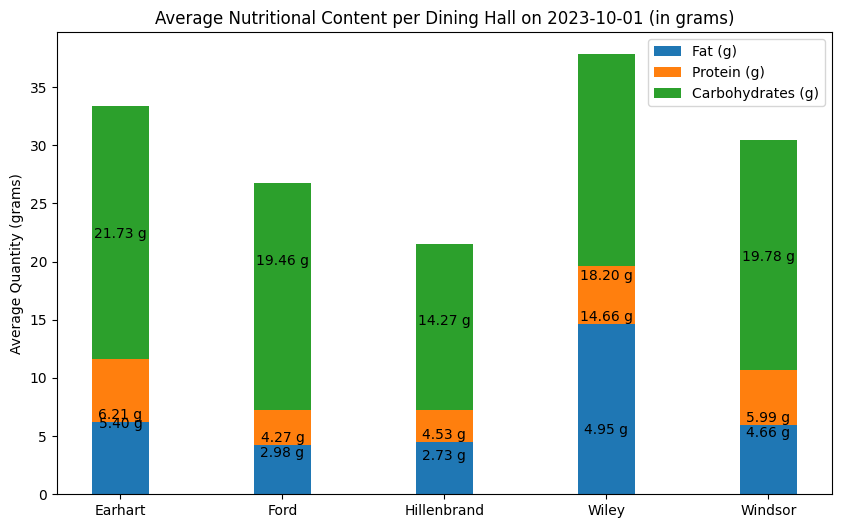

In [78]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import re
import math

# Load the CSV files into DataFrames
menu_items_path = 'menu_items_grouped.csv'
nutritional_details_path = 'nutritional_details.csv'

# Reading the data from each file
menu_items_df = pd.read_csv(menu_items_path)
nutritional_details_df = pd.read_csv(nutritional_details_path)

# Select the first date from the menu_items_grouped dataframe
selected_date = menu_items_df.iloc[0, 0]

# Extract the meal data for each dining hall
dining_halls = menu_items_df.columns[1:]  # Skip the first column as it's the date column
meal_data = {hall: json.loads(menu_items_df[hall][0].replace("'", "\"")) for hall in dining_halls}

# Extract the item_ids for each dining hall
item_ids_per_hall = {hall: [item_id for meal in hall_meals for item_id in meal['item_ids']] 
                     for hall, hall_meals in meal_data.items()}

# Convert the nutritional details DataFrame to a dictionary for faster access
nutritional_details_dict = nutritional_details_df.set_index('ItemID').T.to_dict()

# Initialize a dictionary to hold the nutritional info sums for each dining hall
nutritional_info_sums = {hall: {'TotalFat': 0, 'Protein': 0, 'TotalCarbohydrate': 0, 'ItemCount': 0}
                         for hall in dining_halls}

# Define a function to clean and convert the nutritional values to float
def clean_and_convert(value):
    # If the value is already a float or int, we return it directly
    if isinstance(value, (int, float)) and not math.isnan(value):
        return value

    # If it's None, we can decide to return it as is or convert to 0 or another placeholder value
    if value is None:
        return 0  # or whatever makes sense in context

    # Now we know the value should be a string, ensure it's converted to string
    value_str = str(value)
    # Remove any non-digit characters including the decimal point
    cleaned_value = re.sub(r'[^\d.]+', '', value_str)
    try:
        # Convert the cleaned string to float
        return float(cleaned_value)
    except ValueError:
        # In case the string is not a valid number, return None or handle it as needed
        return 0


# Calculate the sum of Total Fat, Protein, and Carbohydrates for each dining hall
for hall, item_ids in item_ids_per_hall.items():
    for item_id in item_ids:
        if item_id not in nutritional_details_dict:
            continue
        item_nutrition = nutritional_details_dict[item_id]
        print(f"item_nutrition: {item_nutrition}")
        print(f"total fat {item_nutrition['TotalFat']}, protein {item_nutrition['Protein']}, carbs {item_nutrition['TotalCarbohydrate']}")
        print(f"cleaned fat {clean_and_convert(item_nutrition['TotalFat'])}, protein {clean_and_convert(item_nutrition['Protein'])}, carbs {clean_and_convert(item_nutrition['TotalCarbohydrate'])}")
        nutritional_info_sums[hall]['TotalFat'] += clean_and_convert(item_nutrition['TotalFat'])
        nutritional_info_sums[hall]['Protein'] += clean_and_convert(item_nutrition['Protein'])
        nutritional_info_sums[hall]['TotalCarbohydrate'] += clean_and_convert(item_nutrition['TotalCarbohydrate'])
        nutritional_info_sums[hall]['ItemCount'] += 1
        print(f"nutrition_info_sums: {nutritional_info_sums}")

# Calculate the average nutritional info for each dining hall
average_nutritional_info = {hall: {
    'AverageTotalFat': sums['TotalFat'] / sums['ItemCount'] if sums['ItemCount'] > 0 else 0,
    'AverageProtein': sums['Protein'] / sums['ItemCount'] if sums['ItemCount'] > 0 else 0,
    'AverageCarbohydrate': sums['TotalCarbohydrate'] / sums['ItemCount'] if sums['ItemCount'] > 0 else 0
} for hall, sums in nutritional_info_sums.items()}

print(f'avg nutritional info: {average_nutritional_info}')

# Data preparation for plotting
categories = ['AverageTotalFat', 'AverageProtein', 'AverageCarbohydrate']
data_for_plotting = {category: [average_nutritional_info[hall][category] for hall in dining_halls] for category in categories}

# Location of bars on the x-axis
ind = range(len(dining_halls))

# Width of a bar 
width = 0.35       

# Plotting with updated titles and labels to reflect the unit of measurement (grams)
graph_title = f"Average Nutritional Content per Dining Hall on {selected_date} (in grams)"

# Plotting the updated graph with the date included in the title
fig, ax = plt.subplots(figsize=(10, 6))

p1 = ax.bar(ind, data_for_plotting['AverageTotalFat'], width, label='Fat (g)')
p2 = ax.bar(ind, data_for_plotting['AverageProtein'], width, bottom=data_for_plotting['AverageTotalFat'], label='Protein (g)')
bottom_for_carbs = [sum(x) for x in zip(data_for_plotting['AverageTotalFat'], data_for_plotting['AverageProtein'])]
p3 = ax.bar(ind, data_for_plotting['AverageCarbohydrate'], width, bottom=bottom_for_carbs, label='Carbohydrates (g)')

ax.set_title(graph_title)
ax.set_xticks(ind)
ax.set_xticklabels(dining_halls)
ax.set_ylabel('Average Quantity (grams)')
ax.legend()

for i, rect in enumerate(p1+p2+p3):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f g' % float(height), ha='center', va='bottom')

plt.show()


In [52]:
nutritional_info_sums[hall]

{'TotalFat': 0, 'Protein': 0, 'TotalCarbohydrate': 0, 'ItemCount': 0}

In [54]:
item_nutrition['TotalFat']

'16.0742'